# COMP.CS.320 Data-Intensive Programming, Exercise 4

This exercise is in two parts and contains tasks related to the use of Spark machine learning library and the low-level distributed datasets, RDDs. The tasks can be done in either Scala or Python. This is the **Python** version, switch to the Scala version if you want to do the tasks in Scala.

- Tasks 1-4 goes through an ML example by training a linear regression model to 2-dimensional data and then using the trained model.
- Tasks 5-7 provides some examples for the usage of RDDs.

Each task has its own cell for the code. Add your solutions to the cells. You are free to add more cells if you feel it is necessary. There are cells with example outputs or test code following most of the tasks.

Don't forget to submit your solutions to Moodle.

In [0]:
# some imports that might be required in the tasks

from typing import List, Tuple

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import functions
from pyspark.sql.types import *


In [0]:
# the initial data for the linear regression tasks
hugeSequenceOfXYData: List[Row] = [
    Row(0.0, 0.0), Row(0.3, 0.5), Row(0.9, 0.8), Row(1.0, 0.8), Row(5.2, 5.8), Row(6.9, 7.2),
    Row(6.4, 6.8), Row(2.0, 2.2), Row(2.2, 2.4), Row(3.0, 3.7), Row(4.0, 4.3), Row(3.8, 4.0),
    Row(7.1, 9.0), Row(1.9, 1.9), Row(1.5, 1.4), Row(3.2, 3.9), Row(3.5, 4.1), Row(1.2, 1.1),
    Row(5.9, 5.7), Row(6.1, 6.7), Row(4.4, 4.6), Row(5.5, 5.2), Row(6.6, 7.2), Row(6.9, 7.9),
    Row(3.1, 4.0), Row(0.1, 0.2), Row(7.8, 8.8), Row(4.7, 5.0), Row(4.8, 5.0), Row(7.5, 8.2)
]
dataRDD: RDD[Row] = spark.sparkContext.parallelize(hugeSequenceOfXYData)


## Task 1 - Linear regression - Creating data frame

### Background

Wikipedia defines: [Simple Linear Regression](https://en.wikipedia.org/wiki/Simple_linear_regression)

In statistics, simple linear regression is a linear regression model with a single explanatory variable.
That is, it concerns two-dimensional sample points with one independent variable and one dependent variable
(conventionally, the x and y coordinates in a Cartesian coordinate system) and finds a linear function (a non-vertical straight line)
that, as accurately as possible, predicts the dependent variable values as a function of the independent variable.
The adjective simple refers to the fact that the outcome variable is related to a single predictor.

You are given an `dataRDD` of Rows (the first element are the `x` and the second the `y` values). We are aiming at finding simple linear regression model
for the dataset using Spark ML library. I.e. find a function `f` so that `y = f(x)` (for the 2-dimensional case `f(x)=ax+b`).

### Task instructions

Transform the given `dataRDD` to a DataFrame `dataDF`, with two columns `X` (of type Double) and `label` (of type Double).
(`label`used here because that is the default dependent variable name in Spark ML library)

Then split the rows in the data frame into training and testing data frames.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
schema = StructType([
    StructField("X", DoubleType(), True), StructField("label", DoubleType(), True)])
dataDF: DataFrame = spark.createDataFrame(dataRDD, schema)

# Split the data into training and testing datasets (roughly 80% for training, 20% for testing)
trainTestArray: List[DataFrame] = dataDF.randomSplit([0.8, 0.2], seed=1)

trainingDF: DataFrame = trainTestArray[0]
testDF: DataFrame = trainTestArray[1]

print(f"Training set size: {trainingDF.count()}")
print(f"Test set size: {testDF.count()}")
print("Training set (showing only the first 6 points):")
trainingDF.show(6)


Training set size: 24
Test set size: 6
Training set (showing only the first 6 points):
+---+-----+
|  X|label|
+---+-----+
|0.0|  0.0|
|0.3|  0.5|
|0.9|  0.8|
|1.0|  0.8|
|6.4|  6.8|
|6.9|  7.2|
+---+-----+
only showing top 6 rows



Example output for task 1 (the data splitting done by using seed value of 1 for data frames random splitting method, different values are possible even with the same seed):

```text
Training set size: 24
Test set size: 6
Training set (showing only the first 6 points):
+---+-----+
|  X|label|
+---+-----+
|0.0|  0.0|
|0.3|  0.5|
|0.9|  0.8|
|1.0|  0.8|
|6.4|  6.8|
|6.9|  7.2|
+---+-----+
only showing top 6 rows
```

Your output does not have to match this exactly, not even with the sizes of the training and test sets.


## Task 2 - Linear regression - Training the model

To be able to use the ML algorithms in Spark the input data must be given as vectors in one column. To make it easy to transform the input data into this vector format, Spark offers VectorAssembler objects.

Create a `VectorAssembler` for mapping input column `X` to `features`column and apply it to training data frame, `trainingDF,` in order to create assembled training data frame.

Then create a `LinearRegression` object use it and the assembled training data frame to train a linear regression model.


In [0]:
vectorAssembler: VectorAssembler = VectorAssembler(inputCols=["X"], outputCol="features")

assembledTrainingDF: DataFrame = vectorAssembler.transform(trainingDF)
assembledTrainingDF.show(6)


+---+-----+--------+
|  X|label|features|
+---+-----+--------+
|0.0|  0.0|   [0.0]|
|0.3|  0.5|   [0.3]|
|0.9|  0.8|   [0.9]|
|1.0|  0.8|   [1.0]|
|6.4|  6.8|   [6.4]|
|6.9|  7.2|   [6.9]|
+---+-----+--------+
only showing top 6 rows



In [0]:
lr = LinearRegression(featuresCol="features", labelCol="label")

# you can print explanations for all the parameters that can be used for linear regression by uncommenting the following:
#print(lr.explainParams())

lrModel: LinearRegressionModel = lr.fit(assembledTrainingDF)
lrModel.summary.predictions.show(6)


+---+-----+--------+--------------------+
|  X|label|features|          prediction|
+---+-----+--------+--------------------+
|0.0|  0.0|   [0.0]|-0.09366503067484776|
|0.3|  0.5|   [0.3]|  0.2398981595092013|
|0.9|  0.8|   [0.9]|  0.9070245398772995|
|1.0|  0.8|   [1.0]|  1.0182122699386493|
|6.4|  6.8|   [6.4]|   7.022349693251533|
|6.9|  7.2|   [6.9]|   7.578288343558281|
+---+-----+--------+--------------------+
only showing top 6 rows



Example outputs for task 2:

```text
+---+-----+--------+
|  X|label|features|
+---+-----+--------+
|0.0|  0.0|   [0.0]|
|0.3|  0.5|   [0.3]|
|0.9|  0.8|   [0.9]|
|1.0|  0.8|   [1.0]|
|6.4|  6.8|   [6.4]|
|6.9|  7.2|   [6.9]|
+---+-----+--------+
only showing top 6 rows
```

and

```text
+---+-----+--------+--------------------+
|  X|label|features|          prediction|
+---+-----+--------+--------------------+
|0.0|  0.0|   [0.0]|-0.09366503067484776|
|0.3|  0.5|   [0.3]|  0.2398981595092013|
|0.9|  0.8|   [0.9]|  0.9070245398772995|
|1.0|  0.8|   [1.0]|  1.0182122699386493|
|6.4|  6.8|   [6.4]|   7.022349693251533|
|6.9|  7.2|   [6.9]|   7.578288343558281|
+---+-----+--------+--------------------+
only showing top 6 rows
```


## Task 3 - Linear regression - Test the model

Apply the trained linear regression model from task 2 to the test dataset.

Then calculate the RMSE (root mean square error) for the test dataset predictions using `RegressionEvaluator` from Spark ML library.

(The cell after the example output can be used to visualize the linear regression tasks)


In [0]:
testPredictions: DataFrame = lrModel.transform(vectorAssembler.transform(testDF))
testPredictions.show()

testEvaluator: RegressionEvaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# you can print explanations for all the parameters that can be used for the regression evaluator by uncommenting the following:
# print(testEvaluator.explainParams())

testError: float = testEvaluator.evaluate(testPredictions)
print(f"The RMSE for the model is {testError}")


+---+-----+--------+--------------------+
|  X|label|features|          prediction|
+---+-----+--------+--------------------+
|5.2|  5.8|   [5.2]|   5.688096932515337|
|3.8|  4.0|   [3.8]|    4.13146871165644|
|3.2|  3.9|   [3.2]|   3.464342331288343|
|6.1|  6.7|   [6.1]|   6.688786503067483|
|0.1|  0.2|   [0.1]|0.017522699386501944|
|7.5|  8.2|   [7.5]|    8.24541472392638|
+---+-----+--------+--------------------+

The RMSE for the model is 0.20619171009294207


Example output for task 3:

```text
+---+-----+--------+--------------------+
|  X|label|features|          prediction|
+---+-----+--------+--------------------+
|5.2|  5.8|   [5.2]|   5.688096932515337|
|3.8|  4.0|   [3.8]|    4.13146871165644|
|3.2|  3.9|   [3.2]|   3.464342331288343|
|6.1|  6.7|   [6.1]|   6.688786503067483|
|0.1|  0.2|   [0.1]|0.017522699386501944|
|7.5|  8.2|   [7.5]|    8.24541472392638|
+---+-----+--------+--------------------+

The RMSE for the model is 0.20619171009294207
```

0 for RMSE would indicate perfect fit and the more deviations there are the larger RMSE will be.

You can try different seed for dividing the data and different parameters for the linear regression to get different results.


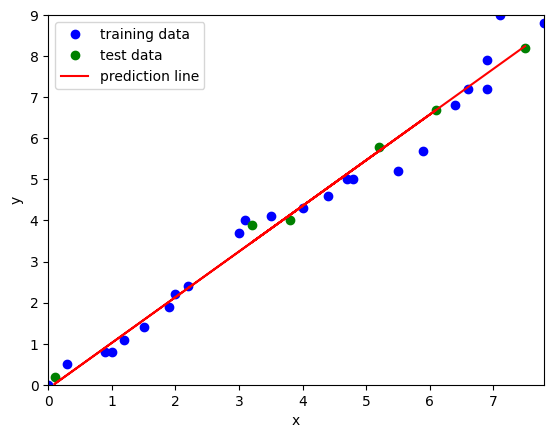

In [0]:
# visualization of the linear regression exercise (can be done since there are only limited number of source data points)
from matplotlib import pyplot

training_data = trainingDF.collect()
test_data = testDF.collect()
test_predictions = testPredictions.collect()

x_values_training = [row[0] for row in training_data]
y_values_training = [row[1] for row in training_data]
x_values_test = [row[0] for row in test_data]
y_values_test = [row[1] for row in test_data]
x_predictions = [row[0] for row in test_predictions]
y_predictions = [row[3] for row in test_predictions]

pyplot.xlabel("x")
pyplot.ylabel("y")
pyplot.xlim(min(x_values_training+x_values_test), max(x_values_training+x_values_test))
pyplot.ylim(min(y_values_training+y_values_test), max(y_values_training+y_values_test))
pyplot.plot(x_values_training, y_values_training, 'bo')
pyplot.plot(x_values_test, y_values_test, 'go')
pyplot.plot(x_predictions, y_predictions, 'r-')
pyplot.legend(["training data", "test data", "prediction line"])
pyplot.show()


## Task 4 - Linear regression - making predictions

Use the trained `LinearRegressionModel` from task 2 to predict the `y` values for the following `x` values: `-1.5`, `2.5`, `8.5`, `31.4`


In [0]:
given_values = [(x,) for x in [-1.5, 2.5, 8.5, 31.4]]
given_valuesDataFrame = spark.createDataFrame(given_values, ['X'])

given_valuesDataFrame_vectorAssemble = lrModel.transform(vectorAssembler.transform(given_valuesDataFrame))
given_valuesDataFrame_vectorAssemble.select('X', 'prediction').show()


+----+-------------------+
|   X|         prediction|
+----+-------------------+
|-1.5|-1.7614809815950931|
| 2.5| 2.6860282208588946|
| 8.5|  9.357292024539877|
|31.4|  34.81928220858895|
+----+-------------------+



Example output for task 4:

```text
+----+-------------------+
|   X|         prediction|
+----+-------------------+
|-1.5|-1.7614809815950931|
| 2.5| 2.6860282208588946|
| 8.5|  9.357292024539877|
|31.4|  34.81928220858895|
+----+-------------------+
```


## Task 5 - RDD - Loading text data

There are three scientific articles in the [shared container](https://portal.azure.com/#view/Microsoft_Azure_Storage/ContainerMenuBlade/~/overview/storageAccountId/%2Fsubscriptions%2Fe0c78478-e7f8-429c-a25f-015eae9f54bb%2FresourceGroups%2Ftuni-cs320-f2023-rg%2Fproviders%2FMicrosoft.Storage%2FstorageAccounts%2Ftunics320f2023gen2/path/shared/etag/%220x8DBB0695B02FFFE%22/defaultEncryptionScope/%24account-encryption-key/denyEncryptionScopeOverride~/false/defaultId//publicAccessVal/None) at folder `exercises/ex4/`. The direct address to the folder is: `abfss://shared@tunics320f2023gen2.dfs.core.windows.net/exercises/ex4`.

Load the text from the articles into a single RDD.

Then count the total number of lines in the articles and print out the first 10 lines from the RDD.


In [0]:
articlesRdd: RDD[str] = spark.sparkContext.textFile('abfss://shared@tunics320f2023gen2.dfs.core.windows.net/exercises/ex4')  

numberOfLines: int = articlesRdd.count()
print(f"numberOfLines: {numberOfLines}")

lines10: List[str] = articlesRdd.take(10)
print("=============================================================")
print(*lines10, sep="\n")
print("=============================================================")


numberOfLines: 2919
Journal of Universal Computer Science, vol. 7, no. 1 (2001), 3-18
submitted: 1/9/00, accepted: 13/10/00, appeared: 28/1/01  Springer Pub. Co.

DisCo Toolset - The New Generation
Timo Aaltonen
(Tampere University of Technology, Finland
timo.aaltonen@tut.fi)

Mika Katara
(Tampere University of Technology, Finland


Example output for task 5:

```text
numberOfLines: 2919
=============================================================
Journal of Universal Computer Science, vol. 7, no. 1 (2001), 3-18
submitted: 1/9/00, accepted: 13/10/00, appeared: 28/1/01  Springer Pub. Co.

DisCo Toolset - The New Generation
Timo Aaltonen
(Tampere University of Technology, Finland
timo.aaltonen@tut.fi)

Mika Katara
(Tampere University of Technology, Finland
=============================================================
```

If you load the articles in a different order, you might get different output for the first 10 lines here.


## Task 6 - RDD - Counting elements

Using the `articlesRDD` defined in task 5 to count the total number of words in the articles. (you can assume that words are separated from each by white space characters, '` `')

Then count the total number of non-white space characters in the articles.


In [0]:
numberOfWords: int = articlesRdd.flatMap(lambda line: line.split()).count()
print(f"numberOfWords: {numberOfWords}")

numberOfCharacters: int = articlesRdd.map(lambda article: len(article.replace(" ", ""))).reduce(lambda x, y: x + y)
print(f"numberOfCharacters: {numberOfCharacters}")


numberOfWords: 17333
numberOfCharacters: 95171


Example output for task 6:

```text
numberOfWords: 17333
numberOfCharacters: 95171
```


## Task 7 - RDD - Most common word

For the final RDD task in this exercise find the answers to the following questions.

- How many 6-letter words are there in the corpus?
- What is the most often appearing 6-letter word and how many times does it appear?


In [0]:
words6Count: int = articlesRdd.flatMap(lambda line: line.split()).filter(lambda word: len(word) == 6).count()
print(f"6-letter words: {words6Count}")

wordCounts = articlesRdd.flatMap(lambda line: line.split()).filter(lambda word: len(word) == 6).countByValue()

commonWord: str = max(wordCounts, key=wordCounts.get)
commonWordCount: int = wordCounts[commonWord]
print(f"The most common 6-letter word is '{commonWord}' and it appears {commonWordCount} times")


6-letter words: 1188
The most common 6-letter word is 'action' and it appears 102 times


Example output for task 7:

```text
6-letter words: 1188
The most common 6-letter word is 'action' and it appears 102 times
```
